In [55]:
import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import lars_path, LinearRegression, Lasso, LassoCV
from sklearn.metrics import r2_score, mean_squared_error
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import requests, io, re

from patsy import dmatrices
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import partial_dependence, permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [56]:
# Import data

data_oct = pd.read_csv("/Users/Admin/Desktop/listings_OCT_FINAL.csv")
#data_oct = pd.read_csv("/Users/jacopobinati/Desktop/HM2/listings_OCT_FINAL.csv")
data_oct.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,...,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,ln_price,property_House,property_Private room,property_Shared Room
0,NaN,NaN,f,1.0,2.0,"['email', 'phone']",t,f,Bushwick,Brooklyn,...,5.00,1,0,1,0,0.06,4.174387,False,True,False
1,NaN,NaN,f,1.0,1.0,"['email', 'phone']",t,t,Hell's Kitchen,Manhattan,...,NaN,1,0,1,0,NaN,4.700480,False,True,False
2,NaN,NaN,f,1.0,1.0,"['email', 'phone']",t,f,Sunnyside,Queens,...,NaN,1,1,0,0,NaN,4.595120,True,False,False
3,NaN,NaN,f,1.0,2.0,"['email', 'phone', 'work_email']",t,t,Bedford-Stuyvesant,Brooklyn,...,5.00,1,1,0,0,0.03,4.248495,True,False,False
4,NaN,100%,t,1.0,1.0,"['email', 'phone']",t,t,Bedford-Stuyvesant,Brooklyn,...,4.92,1,1,0,0,1.26,5.135798,True,False,False


In [57]:
#Drop columns that are not needed

columns_to_drop = ['host_verifications', 'latitude', 'longitude', 'host_listings_count',
                   'host_total_listings_count', 'maximum_nights_avg_ntm', 'minimum_minimum_nights', 'calendar_last_scraped',
                   'first_review']

data_oct.drop(columns_to_drop, axis=1, inplace=True)


In [58]:
# Keep obs with 2 < accommodates < 6, and property_House = 1 only

data_oct = data_oct[(data_oct['accommodates'] >= 2) & (data_oct['accommodates'] <= 6) & (data_oct['property_House'] == 1)]


In [59]:
# Formatting columns    
for binary in [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "has_availability",
]:
    data_oct[binary] = data_oct[binary].map({"t": True, "f": False})

data_oct["f_property_type"] = data_oct["property_type"].astype("category")
data_oct['f_neighbourhood_group_cleansed'] = data_oct['neighbourhood_group_cleansed'].astype("category")
data_oct["f_neighbourhood_cleansed"] = data_oct["neighbourhood_cleansed"].astype("category")
data_oct['n_bathroom'] = data_oct['bathrooms_text'].str.extract('(\d+\.?\d*)').astype(float)
data_oct['host_acceptance_rate'] = data_oct['host_acceptance_rate'].str.replace('%', '').astype(float)
data_oct['host_response_rate'] = data_oct['host_response_rate'].str.replace('%', '').astype(float)

In [60]:
# add new numeric columns from certain columns

numericals = [
    "accommodates",
    "availability_365",
    "review_scores_value",
    "number_of_reviews_ltm",
    "number_of_reviews_l30d",
    "review_scores_location",
    "review_scores_communication",
    "review_scores_checkin",
    "review_scores_cleanliness",
    "reviews_per_month",
    "minimum_nights",
    "maximum_nights",
    "beds",
    #"bedrooms",
    "host_acceptance_rate",
    "host_response_rate",
]

for col in numericals:
    data_oct["n_" + col] = pd.to_numeric(data_oct[col], errors="coerce")

In [61]:
#Assign mean values to missing ones

data_oct["n_review_scores_value"].fillna(data_oct["n_review_scores_value"].mean(), inplace=True)
data_oct["n_review_scores_location"].fillna(data_oct["n_review_scores_location"].mean(), inplace=True)
data_oct["n_review_scores_communication"].fillna(data_oct["n_review_scores_communication"].mean(), inplace=True)
data_oct["n_review_scores_checkin"].fillna(data_oct["n_review_scores_checkin"].mean(), inplace=True)
data_oct["n_reviews_per_month"].fillna(data_oct["n_reviews_per_month"].mean(), inplace=True)
#data_oct["n_bedrooms"].fillna(data_oct["n_bedrooms"].mean(), inplace=True)
data_oct["n_host_acceptance_rate"].fillna(data_oct["n_host_acceptance_rate"].mean(), inplace=True)
data_oct["n_host_response_rate"].fillna(data_oct["n_host_response_rate"].mean(), inplace=True)

data_oct = data_oct.assign(
    flag_review_scores_value=np.multiply(data_oct.n_review_scores_value.isna(), 1),
    n_review_scores_value=data_oct.n_review_scores_value.fillna(
        np.mean(data_oct.n_review_scores_value.dropna())
    ),
    flag_review_scores_location=np.multiply(data_oct.n_review_scores_location.isna(), 1),
    n_review_scores_location=data_oct.n_review_scores_location.fillna(
        np.mean(data_oct.n_review_scores_location.dropna())
    ),

    flag_review_scores_communication=np.multiply(data_oct.n_review_scores_communication.isna(), 1),
    n_review_scores_communication=data_oct.n_review_scores_communication.fillna(
        np.mean(data_oct.n_review_scores_communication.dropna())
    ),

    flag_review_scores_checkin=np.multiply(data_oct.n_review_scores_checkin.isna(), 1),
    n_review_scores_checkin=data_oct.n_review_scores_checkin.fillna(
        np.mean(data_oct.n_review_scores_checkin.dropna())
    ),

    flag_reviews_per_month=np.multiply(data_oct.n_reviews_per_month.isna(), 1),
    n_reviews_per_month=data_oct.n_reviews_per_month.fillna(
        np.mean(data_oct.n_reviews_per_month.dropna())
    ),

    flag_review_scores_cleanliness=np.multiply(data_oct.n_review_scores_cleanliness.isna(), 1),
    n_review_scores_cleanliness=data_oct.n_review_scores_cleanliness.fillna(
        np.mean(data_oct.n_review_scores_cleanliness.dropna())
    ),

    flag_host_acceptance_rate=np.multiply(data_oct.host_acceptance_rate.isna(), 1),
    n_host_acceptance_rate=data_oct.host_acceptance_rate.fillna(
        np.mean(data_oct.host_acceptance_rate.dropna())
    ),
    flag_host_response_rate=np.multiply(data_oct.host_response_rate.isna(), 1),
    n_host_response_rate=data_oct.host_response_rate.fillna(
        np.mean(data_oct.host_response_rate.dropna())
    )

)

In [62]:
 '''
    flag_bedrooms=np.multiply(data_oct.n_bedrooms.isna(), 1),
    n_bedrooms=data_oct.n_bedrooms.fillna(
        np.mean(data_oct.n_bedrooms.dropna())
    ),'''

'\n   flag_bedrooms=np.multiply(data_oct.n_bedrooms.isna(), 1),\n   n_bedrooms=data_oct.n_bedrooms.fillna(\n       np.mean(data_oct.n_bedrooms.dropna())\n   ),'

In [63]:
columns_to_check = ['n_bathroom', 'n_beds', 'host_has_profile_pic', 'host_is_superhost', 'host_identity_verified']
data_oct.dropna(subset=columns_to_check, inplace=True)

In [64]:
# Remove various strings, split amenities and turn into dtype:object

replace_str_dict = {
    '"' : "",
    ", " : ",",
    "\\\\" : "",
    ":" : "",
    "\\+" : "_",
}

data_oct["amenities"] = data_oct["amenities"].replace(replace_str_dict, regex=True).str.strip("[]").str.split(",")

In [65]:
# Function to merge amenities containing any keyword from a dictionary (case-insensitive)
def merge_items_with_keywords(amenities_list, merge_dict):
    merged_amenities = []
    for amenities in amenities_list:
        merged_item = []
        for amenity in amenities:
            lower_amenity = amenity.lower()
            for new_category, old_categories in merge_dict.items():
                if any(old_category in lower_amenity for old_category in old_categories):
                    merged_item.append(new_category)
                    break
            else:
                merged_item.append(amenity)
        merged_amenities.append(list(set(merged_item)))
    return merged_amenities

In [66]:
# Dictionary to merge amenities

merge_dict = {
    'wifi': ['wifi'],
    'kitchen': ['kitchen', 'kitchenette'],
    'stove': ['stove'],
    'oven': ['oven'],
    'microwave': ['microwave'],
    'refrigerator': ['refrigerator', 'fridge'],
    'dishwasher': ['dishwasher'],
    'kettel': ['kettle'],
    'toaster': ['toaster'],
    'coffee': ['coffee maker', 'machine', 'coffee', 'espresso', 'nespresso'],
    'tv': ['tv'],
    'sound_system': ['speaker', 'sound'],
    'game_console': ['game console', 'ps2', 'ps3', 'ps4', 'ps5', 
                     'playstation', 'wii', 'xbox'],
    'baby': ['baby', 'toys'],
    'body_wash': ['body', 'soap', 'shower gel'],
    'shampoo': ['shampoo'],
    'conditioner': ['conditioner'],
    'hair dryer': ['hair dryer'],
    'laundry': ['washer', 'laundry'],
    'backyard': ['backyard'],
    'grill': ['grill'],
    'breakfast': ['breakfast'],
    'clothing_storage': ['clothing storage'],
    'ac': ['ac - split type ductless system', 'air conditioning', 'central air conditioning', 'window ac unit'],
    'heating': ['heating']
}

In [67]:
# Merge some amenities together

data_oct['amenities'] = merge_items_with_keywords(data_oct['amenities'], merge_dict)

In [68]:
# Generate dummies by amenities

dummies = data_oct['amenities'].str.join('|').str.get_dummies()
dummies.columns = "d_" + dummies.columns.str.replace('/', '_').str.replace(' ', '_').str.replace('-', '_').str.replace('\\\\', '')

In [69]:
dummies.head()

,d_000_BTU_in_the_Bedroom_and_12,d_2_5_years_old,d_5_10_years_old,d_9,d_Amazon_Prime_Video,d_Avanti,d_Baking_sheet,d_Barbecue_utensils,d_Bathtub,d_Bay_view,...,d_stationary_bike,d_stove,d_tesla_only,d_toaster,d_treadmill,d_tv,d_wardrobe,d_wifi,d_wood_burning,d_yoga_mat
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,1,0,1,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,0,0,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [70]:
# Top amenities in NYC
top_150_columns = dummies.sum().sort_values(ascending=False).head(150).index
final_dummies = dummies[top_150_columns]

In [71]:
final_dummies.head()

,d_wifi,d_kitchen,d_ac,d_Smoke_alarm,d_heating,d_tv,d_Essentials,d_Carbon_monoxide_alarm,d_Hangers,d_hair_dryer,...,d_Beach_access,d_Exercise_equipment_yoga_mat,d_Paid_parking_lot_off_premises,d_Bread_maker,d_EV_charger,d_stationary_bike,d_Pack_u2019n_play_Travel_crib___always_at_the_listing,d_Table_corner_guards,d_Bay_view,d_Free_driveway_parking_on_premises_u2013_1_space
3,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
8,1,1,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,1,1,0,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
14,1,0,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [72]:
#Add dummies amneties to data_oct
data_oct = pd.concat([data_oct, final_dummies], axis=1)

In [73]:
data_oct.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,accommodates,bathrooms_text,...,d_Beach_access,d_Exercise_equipment_yoga_mat,d_Paid_parking_lot_off_premises,d_Bread_maker,d_EV_charger,d_stationary_bike,d_Pack_u2019n_play_Travel_crib___always_at_the_listing,d_Table_corner_guards,d_Bay_view,d_Free_driveway_parking_on_premises_u2013_1_space
3,NaN,NaN,False,True,True,Bedford-Stuyvesant,Brooklyn,House,2,1 bath,...,0,0,0,0,0,0,0,0,0,0
4,NaN,100.0,True,True,True,Bedford-Stuyvesant,Brooklyn,House,4,1 bath,...,0,0,0,0,0,0,0,0,0,0
8,NaN,NaN,False,True,True,Kips Bay,Manhattan,House,2,1 bath,...,0,0,0,0,0,0,0,0,0,0
9,NaN,0.0,False,True,False,Crown Heights,Brooklyn,House,2,1 bath,...,0,0,0,0,0,0,0,0,0,0
14,100.0,99.0,False,True,True,Williamsburg,Brooklyn,House,2,1 bath,...,0,0,0,0,0,0,0,0,0,0


In [74]:
# Basic Variables inc neighnourhood
basic_vars = [
    "n_accommodates",
    #"n_bedrooms",
    "n_bathroom",
    "n_beds",
    #"f_neighbourhood_cleansed",
    'f_neighbourhood_group_cleansed',
    "n_availability_365",
    "n_minimum_nights",
    "n_maximum_nights",
    "host_is_superhost",
    "n_host_acceptance_rate",
    "host_has_profile_pic",
    "n_host_response_rate",
]

# reviews
reviews = [
    "n_review_scores_value",
    "flag_review_scores_value",
    "n_review_scores_location",
    "flag_review_scores_location",
    "n_review_scores_communication",
    "flag_review_scores_communication",
    "n_review_scores_checkin",
    "flag_review_scores_checkin",
    "n_review_scores_cleanliness",
    "flag_review_scores_cleanliness",
    "n_reviews_per_month",
    "flag_reviews_per_month"
]

# Dummy variables
amenities = [col for col in data_oct if col.startswith("d_")]

# interactions for the LASSO
# from ch14
X1 = [
    "n_accommodates:d_wifi",
    "d_breakfast:d_kitchen",
    "d_heating:n_accommodates",
    #"d_ac:n_bedrooms",
    "n_minimum_nights:n_accommodates",
    "n_availability_365:minimum_nights",
    "n_review_scores_value:n_reviews_per_month",
    "n_host_acceptance_rate:n_host_response_rate",
    "host_identity_verified:host_is_superhost",
]
# with neighbourhood
X2 = [
    "n_availability_365:f_neighbourhood_group_cleansed",
    "n_accommodates:f_neighbourhood_group_cleansed",
    "d_wifi:f_neighbourhood_group_cleansed",
    "d_Smoke_alarm:f_neighbourhood_group_cleansed",
]

In [75]:
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + amenities
predictors_3 = basic_vars + reviews + amenities + X1 + X2

In [76]:
amenities

['d_wifi',
 'd_kitchen',
 'd_ac',
 'd_Smoke_alarm',
 'd_heating',
 'd_tv',
 'd_Essentials',
 'd_Carbon_monoxide_alarm',
 'd_Hangers',
 'd_hair_dryer',
 'd_Iron',
 'd_Hot_water',
 'd_refrigerator',
 'd_shampoo',
 'd_Dishes_and_silverware',
 'd_Cooking_basics',
 'd_coffee',
 'd_Bed_linens',
 'd_microwave',
 'd_oven',
 'd_stove',
 'd_laundry',
 'd_Dedicated_workspace',
 'd_Self_check_in',
 'd_Fire_extinguisher',
 'd_Long_term_stays_allowed',
 'd_Free_street_parking',
 'd_Extra_pillows_and_blankets',
 'd_First_aid_kit',
 'd_Bathtub',
 'd_body_wash',
 'd_Cleaning_products',
 'd_clothing_storage',
 'd_Private_entrance',
 'd_Freezer',
 'd_dishwasher',
 'd_Pets_allowed',
 'd_Dining_table',
 'd_Elevator',
 'd_kettel',
 'd_Wine_glasses',
 'd_Dryer',
 'd_Lockbox',
 'd_toaster',
 'd_conditioner',
 'd_Laundromat_nearby',
 'd_Room_darkening_shades',
 'd_Security_cameras_on_property',
 'd_Luggage_dropoff_allowed',
 'd_Baking_sheet',
 'd_backyard',
 'd_Blender',
 'd_Books_and_reading_material',
 'd_Fr

In [125]:
data_oct.to_csv('/Users/Admin/Desktop/listings_OCT_FINAL2.csv', index=False)

In [78]:
#Split the data
data_train, data_holdout = train_test_split(data_oct, train_size=0.8, random_state=42)

In [79]:
data_oct.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,accommodates,bathrooms_text,...,d_Beach_access,d_Exercise_equipment_yoga_mat,d_Paid_parking_lot_off_premises,d_Bread_maker,d_EV_charger,d_stationary_bike,d_Pack_u2019n_play_Travel_crib___always_at_the_listing,d_Table_corner_guards,d_Bay_view,d_Free_driveway_parking_on_premises_u2013_1_space
3,NaN,NaN,False,True,True,Bedford-Stuyvesant,Brooklyn,House,2,1 bath,...,0,0,0,0,0,0,0,0,0,0
4,NaN,100.0,True,True,True,Bedford-Stuyvesant,Brooklyn,House,4,1 bath,...,0,0,0,0,0,0,0,0,0,0
8,NaN,NaN,False,True,True,Kips Bay,Manhattan,House,2,1 bath,...,0,0,0,0,0,0,0,0,0,0
9,NaN,0.0,False,True,False,Crown Heights,Brooklyn,House,2,1 bath,...,0,0,0,0,0,0,0,0,0,0
14,100.0,99.0,False,True,True,Williamsburg,Brooklyn,House,2,1 bath,...,0,0,0,0,0,0,0,0,0,0


# Random Forest

In [80]:
ncores = 3

In [81]:
rfr = RandomForestRegressor(
    random_state=42,
    criterion="squared_error",
    n_estimators=30,
    oob_score=True,
    n_jobs=-1,
)

tune_grid = {
    "max_features": [10, 12, 14],
    "min_samples_split": [6, 11, 16],
}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

rf_model_2 = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_features=10, min_samples_split=6;, score=-176.205 total time=   0.3s
[CV 2/5] END max_features=10, min_samples_split=6;, score=-342.716 total time=   0.3s
[CV 3/5] END max_features=10, min_samples_split=6;, score=-257.193 total time=   0.3s
[CV 4/5] END max_features=10, min_samples_split=6;, score=-291.349 total time=   0.3s
[CV 5/5] END max_features=10, min_samples_split=6;, score=-208.492 total time=   0.3s
[CV 1/5] END max_features=10, min_samples_split=11;, score=-171.838 total time=   0.2s
[CV 2/5] END max_features=10, min_samples_split=11;, score=-342.431 total time=   0.2s
[CV 3/5] END max_features=10, min_samples_split=11;, score=-261.404 total time=   0.2s
[CV 4/5] END max_features=10, min_samples_split=11;, score=-290.765 total time=   0.2s
[CV 5/5] END max_features=10, min_samples_split=11;, score=-209.760 total time=   0.2s
[CV 1/5] END max_features=10, min_samples_split=16;, score=-173.851 total t

In [82]:
rfr = RandomForestRegressor(
    random_state=42,
    criterion="squared_error",
    n_estimators=30,
    oob_score=True,
    n_jobs=-1,
)

tune_grid = {
    "max_features": [10, 12, 14],
    "min_samples_split": [6, 11, 16],
}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_3), data_train)

rf_model_3 = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_features=10, min_samples_split=6;, score=-174.552 total time=   0.3s
[CV 2/5] END max_features=10, min_samples_split=6;, score=-341.896 total time=   0.3s
[CV 3/5] END max_features=10, min_samples_split=6;, score=-257.605 total time=   0.3s
[CV 4/5] END max_features=10, min_samples_split=6;, score=-289.843 total time=   0.3s
[CV 5/5] END max_features=10, min_samples_split=6;, score=-208.297 total time=   0.4s
[CV 1/5] END max_features=10, min_samples_split=11;, score=-172.953 total time=   0.3s
[CV 2/5] END max_features=10, min_samples_split=11;, score=-342.397 total time=   0.3s
[CV 3/5] END max_features=10, min_samples_split=11;, score=-257.095 total time=   0.3s
[CV 4/5] END max_features=10, min_samples_split=11;, score=-290.332 total time=   0.2s
[CV 5/5] END max_features=10, min_samples_split=11;, score=-209.262 total time=   0.2s
[CV 1/5] END max_features=10, min_samples_split=16;, score=-172.713 total t

In [83]:
pd.DataFrame(rf_model_2.cv_results_)[
    ["param_max_features", "param_min_samples_split", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_max_features"],
    Min_nodes=lambda x: x["param_min_samples_split"] - 1,
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(
    2
)

Variables,10,12,14
Min_nodes,,,
5,255.19,255.00,254.25
10,255.24,254.05,253.78
15,255.20,254.80,254.18


In [84]:
pd.DataFrame(rf_model_3.cv_results_)[
    ["param_max_features", "param_min_samples_split", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_max_features"],
    Min_nodes=lambda x: x["param_min_samples_split"] - 1,
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(
    2
)

Variables,10,12,14
Min_nodes,,,
5,254.44,254.55,254.47
10,254.41,253.85,253.83
15,254.42,253.48,253.09


In [85]:
pd.DataFrame(
    {
        "Min vars": [
            rf_model_2.best_estimator_.max_features,
            rf_model_3.best_estimator_.max_features,
        ],
        "Min nodes": [
            rf_model_2.best_estimator_.min_samples_split - 1,
            rf_model_3.best_estimator_.min_samples_split - 1,
        ],
    },
    ["RF 2", "RF 3"],
)

,Min vars,Min nodes
RF 2,14,10
RF 3,14,15


In [86]:
pd.DataFrame(
    {
        "RMSE": [
            rf_model_2.cv_results_["mean_test_score"].min(),
            rf_model_3.cv_results_["mean_test_score"].min(),
        ]
    },
    ["RF B", "RF C"],
).round(2) * -1

,RMSE
RF B,255.24
RF C,254.55


# OLS

In [87]:
data_oct.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,accommodates,bathrooms_text,...,d_Beach_access,d_Exercise_equipment_yoga_mat,d_Paid_parking_lot_off_premises,d_Bread_maker,d_EV_charger,d_stationary_bike,d_Pack_u2019n_play_Travel_crib___always_at_the_listing,d_Table_corner_guards,d_Bay_view,d_Free_driveway_parking_on_premises_u2013_1_space
3,NaN,NaN,False,True,True,Bedford-Stuyvesant,Brooklyn,House,2,1 bath,...,0,0,0,0,0,0,0,0,0,0
4,NaN,100.0,True,True,True,Bedford-Stuyvesant,Brooklyn,House,4,1 bath,...,0,0,0,0,0,0,0,0,0,0
8,NaN,NaN,False,True,True,Kips Bay,Manhattan,House,2,1 bath,...,0,0,0,0,0,0,0,0,0,0
9,NaN,0.0,False,True,False,Crown Heights,Brooklyn,House,2,1 bath,...,0,0,0,0,0,0,0,0,0,0
14,100.0,99.0,False,True,True,Williamsburg,Brooklyn,House,2,1 bath,...,0,0,0,0,0,0,0,0,0,0


In [88]:
#print(data_oct[basic_vars].dtypes)
print(data_oct[reviews].dtypes)

n_review_scores_value               float64
flag_review_scores_value              int32
n_review_scores_location            float64
flag_review_scores_location           int32
n_review_scores_communication       float64
flag_review_scores_communication      int32
n_review_scores_checkin             float64
flag_review_scores_checkin            int32
n_review_scores_cleanliness         float64
flag_review_scores_cleanliness        int32
n_reviews_per_month                 float64
flag_reviews_per_month                int32
dtype: object


In [89]:
'''
y, X = dmatrices("price ~ " + " + ".join(predictors_1), data_train)
ols_model1 = LinearRegression().fit(X,y)
y_hat1 = ols_model1.predict(X)
ols_rmse1 = mean_squared_error(y,y_hat1,squared=False)

y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_1), data_holdout)
ols_test1 = LinearRegression().fit(X_test,y_test)
y_hat_test1 = ols_test1.predict(X_test)
ols_cv_rmse1 = mean_squared_error(y_test,y_hat_test1,squared=False)
#-----------------------------------#

y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)
ols_model2 = LinearRegression().fit(X,y)
y_hat2 = ols_model2.predict(X)
ols_rmse2 = mean_squared_error(y,y_hat2,squared=False)


y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_holdout)
ols_test2 = LinearRegression().fit(X_test,y_test)
y_hat_test2 = ols_test2.predict(X_test)
ols_cv_rmse2 = mean_squared_error(y_test,y_hat_test2,squared=False)
#-----------------------------------#

y, X = dmatrices("price ~ " + " + ".join(predictors_3), data_train)
ols_model3 = LinearRegression().fit(X,y)
y_hat3 = ols_model3.predict(X)
ols_rmse3 = mean_squared_error(y,y_hat3,squared=False)

y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_3), data_holdout)
ols_test3 = LinearRegression().fit(X_test,y_test)
y_hat_test3 = ols_test3.predict(X_test)
ols_cv_rmse3 = mean_squared_error(y_test,y_hat_test3,squared=False)
'''

'\ny, X = dmatrices("price ~ " + " + ".join(predictors_1), data_train)\nols_model1 = LinearRegression().fit(X,y)\ny_hat1 = ols_model1.predict(X)\nols_rmse1 = mean_squared_error(y,y_hat1,squared=False)\n\ny_test, X_test = dmatrices("price ~ " + " + ".join(predictors_1), data_holdout)\nols_test1 = LinearRegression().fit(X_test,y_test)\ny_hat_test1 = ols_test1.predict(X_test)\nols_cv_rmse1 = mean_squared_error(y_test,y_hat_test1,squared=False)\n#-----------------------------------#\n\ny, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)\nols_model2 = LinearRegression().fit(X,y)\ny_hat2 = ols_model2.predict(X)\nols_rmse2 = mean_squared_error(y,y_hat2,squared=False)\n\n\ny_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_holdout)\nols_test2 = LinearRegression().fit(X_test,y_test)\ny_hat_test2 = ols_test2.predict(X_test)\nols_cv_rmse2 = mean_squared_error(y_test,y_hat_test2,squared=False)\n#-----------------------------------#\n\ny, X = dmatrices("price ~ "

In [90]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [91]:
def cross_validate(data, formula, model, kf):
    rmse_values = []
    for train_index, test_index in kf.split(data):
        data_train, data_test = data.iloc[train_index], data.iloc[test_index]

        y_train, X_train = patsy.dmatrices(formula, data_train)
        y_test, X_test = patsy.dmatrices(formula, data_test)

        results = model(y_train, X_train).fit()

        y_pred = results.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_values.append(rmse)

    average_rmse = np.mean(rmse_values)
    return average_rmse

In [92]:
formulas = [
    ("OLS 1", "price ~ " + " + ".join(predictors_1)),
    ("OLS 2", "price ~ " + " + ".join(predictors_2)),
    ("OLS 3", "price ~ " + " + ".join(predictors_3))
]

rmse_values = []
for model_name, formula in formulas:
    rmse = cross_validate(data_oct, formula, sm.OLS, kf)
    rmse_values.append(rmse)

In [93]:
rmse_values

[441.91257927499225, 466.34757971536675, 424.53217543969487]

In [94]:
'''
formulas_ln = [
    ("Ln OLS 1", "ln_price ~ " + " + ".join(predictors_1)),
    ("Ln OLS 2", "ln_price ~ " + " + ".join(predictors_2)),
    ("Ln OLS 3", "ln_price ~ " + " + ".join(predictors_3))
]
'''

'\nformulas_ln = [\n    ("Ln OLS 1", "ln_price ~ " + " + ".join(predictors_1)),\n    ("Ln OLS 2", "ln_price ~ " + " + ".join(predictors_2)),\n    ("Ln OLS 3", "ln_price ~ " + " + ".join(predictors_3))\n]\n'

In [95]:
'''
ln_rmse_values = []
for model_name, formula in formulas_ln:
    ln_rmse = cross_validate(data_oct, formula, sm.OLS, kf)
    ln_rmse_values.append(ln_rmse)
'''


'\nln_rmse_values = []\nfor model_name, formula in formulas_ln:\n    ln_rmse = cross_validate(data_oct, formula, sm.OLS, kf)\n    ln_rmse_values.append(ln_rmse)\n'

In [96]:
#ln_rmse_values

# LASSO

In [97]:
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [98]:
lambdas = np.arange(0.05, 1.01, 0.05)
print(lambdas)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]


In [99]:
y, X = dmatrices("price ~ " + " + ".join(predictors_3), data_train)
X_featnames = X.design_info.column_names
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [100]:
lasso_fit = LassoCV(alphas=lambdas, cv=5, random_state=42).fit(X, y)

c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15850224.552206635, tolerance: 108758.0115800992
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99670.9609168768, tolerance: 82237.6844138221
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Admin\AppData\Local

In [101]:
lasso_fit.alpha_

1.0

In [102]:
rmse_lambda_folds = (
    pd.DataFrame(lasso_fit.mse_path_, index=lambdas[::-1])
    .apply(np.sqrt)
    .mean(axis=1)
    .to_frame(name="Test RMSE")
    .round(2)
)

In [103]:
'''
lasso_model = ElasticNet(l1_ratio=1, fit_intercept=True)

lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha": [i / 100 for i in range(1, 26, 1)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
    n_jobs=-1,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_3), data_train)
y, X = np.array(y), np.array(X)

lasso_model_cv.fit(X, y.ravel())

lasso_rmse = (
    pd.DataFrame(lasso_model_cv.cv_results_)
    .loc[lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha]
    .mean_test_score.values[0]
    * -1
)
'''
#lasso_rmse

'\nlasso_model = ElasticNet(l1_ratio=1, fit_intercept=True)\n\nlasso_model_cv = GridSearchCV(\n    lasso_model,\n    {"alpha": [i / 100 for i in range(1, 26, 1)]},\n    cv=5,\n    scoring="neg_root_mean_squared_error",\n    verbose=3,\n    n_jobs=-1,\n)\n\ny, X = dmatrices("price ~ " + " + ".join(predictors_3), data_train)\ny, X = np.array(y), np.array(X)\n\nlasso_model_cv.fit(X, y.ravel())\n\nlasso_rmse = (\n    pd.DataFrame(lasso_model_cv.cv_results_)\n    .loc[lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha]\n    .mean_test_score.values[0]\n    * -1\n)\n'

# Final Comparison for October

In [104]:
rmse_values.extend([rmse_lambda_folds.loc[lasso_fit.alpha_].values[0], rf_model_2.cv_results_["mean_test_score"].min() * -1])
model_names = ['OLS 1', 'OLS 2', 'OLS 3', 'LASSO 1', 'RF 3']

df = pd.DataFrame({'Model': model_names, 'Test RMSE': rmse_values})

df['Test RMSE'] = df['Test RMSE'].round(2)

print(df)  

     Model  Test RMSE
0    OLS 1     441.91
1    OLS 2     466.35
2    OLS 3     424.53
3  LASSO 1     256.55
4     RF 3     255.24


In [105]:
'''
rf_model_2_var_imp_df = (
    pd.DataFrame(
        rf_model_2.best_estimator_.feature_importances_, X.design_info.column_names
    )
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(
        imp_percentage=lambda x: x["imp"] / x["imp"].sum(),
        varname=lambda x: x.varname.str.replace(
            "f_room_type[T.", "Room type:", regex=False
        )
        .str.replace("f_neighbourhood_cleansed[T.", "Borough:", regex=False)
        .str.replace("]", "", regex=False),
    )
    .sort_values(by=["imp"], ascending=False)
)

'''

'\nrf_model_2_var_imp_df = (\n    pd.DataFrame(\n        rf_model_2.best_estimator_.feature_importances_, X.design_info.column_names\n    )\n    .reset_index()\n    .rename({"index": "varname", 0: "imp"}, axis=1)\n    .assign(\n        imp_percentage=lambda x: x["imp"] / x["imp"].sum(),\n        varname=lambda x: x.varname.str.replace(\n            "f_room_type[T.", "Room type:", regex=False\n        )\n        .str.replace("f_neighbourhood_cleansed[T.", "Borough:", regex=False)\n        .str.replace("]", "", regex=False),\n    )\n    .sort_values(by=["imp"], ascending=False)\n)\n\n'

In [106]:
'''
subset_df = rf_model_2_var_imp_df.iloc[:10, :]
color = ['blue']
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(subset_df['varname'], subset_df['imp_percentage'], color=color[0], s=60, label='Variable Importance')
for index, row in subset_df.iterrows():
    ax.plot([row['varname'], row['varname']], [0, row['imp_percentage']], color=color[0], linewidth=2)

ax.set_ylabel('Importance (Percent)')
ax.set_xlabel('Variable Name')
ax.set_title('Variable Importance')
plt.xticks(rotation=90)
ax.grid(True)
plt.tight_layout()
plt.show()
'''

"\nsubset_df = rf_model_2_var_imp_df.iloc[:10, :]\ncolor = ['blue']\nfig, ax = plt.subplots(figsize=(8, 6))\nax.scatter(subset_df['varname'], subset_df['imp_percentage'], color=color[0], s=60, label='Variable Importance')\nfor index, row in subset_df.iterrows():\n    ax.plot([row['varname'], row['varname']], [0, row['imp_percentage']], color=color[0], linewidth=2)\n\nax.set_ylabel('Importance (Percent)')\nax.set_xlabel('Variable Name')\nax.set_title('Variable Importance')\nplt.xticks(rotation=90)\nax.grid(True)\nplt.tight_layout()\nplt.show()\n"

# SHAP

In [107]:
import shap
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_transformer

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [115]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

In [116]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

rf_best_pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", rf_model_2.best_estimator_),
    ]
)

In [117]:
# Fit the ColumnTransformer on the training data
rf_best_pipeline["preprocess"].fit(data_holdout.filter(predictors_2))

# Now you can use it to transform the holdout data
X_encoded = rf_best_pipeline["preprocess"].transform(data_holdout.filter(predictors_2))

new_feature_names = [
    i.replace("cat__", "").replace("num__", "")
    for i in rf_best_pipeline["preprocess"].get_feature_names_out()
]

X_holdout = pd.DataFrame(X_encoded, columns=new_feature_names)
X_holdout = X_holdout.astype(int)


In [118]:
# Initialize a counter
counter = 0

# Print different categories in categorical columns for train and holdout sets
for col in categorical_columns:
    train_unique = set(data_train[col])
    holdout_unique = set(data_holdout[col])
    diff_categories = train_unique - holdout_unique
    if diff_categories:
        print(f"Different categories in {col}: {diff_categories}")
        counter += len(diff_categories)

print("Total number of different categories:", counter)

Total number of different categories: 0


In [119]:
for category in diff_categories:
    X_holdout[f"f_neighbourhood_cleansed_{category}"] = 0

In [113]:
#X_holdout['placeholder'] = 0

In [120]:
explainer = shap.Explainer(rf_best_pipeline["regressor"].predict, X_holdout)
shap_values = explainer(X_holdout)

X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names
X has feature names, but RandomForestReg

In [ ]:
rf_best_pipeline["preprocess"].fit(data_train.filter(predictors_2))
X_encoded_train = rf_best_pipeline["preprocess"].transform(data_train.filter(predictors_2))

feature_names = [
    i.replace("cat__", "").replace("num__", "")
    for i in rf_best_pipeline["preprocess"].get_feature_names_out()
]

len(feature_names)

387

In [ ]:
feature_names = set(feature_names)

In [ ]:
holdout_features_encoded = set(X_holdout.columns)
len(holdout_features_encoded)

388

In [ ]:
missing_features_encoded =  holdout_features_encoded - feature_names

for feature in missing_features_encoded:
    print(feature)

f_neighbourhood_cleansed_Lighthouse Hill


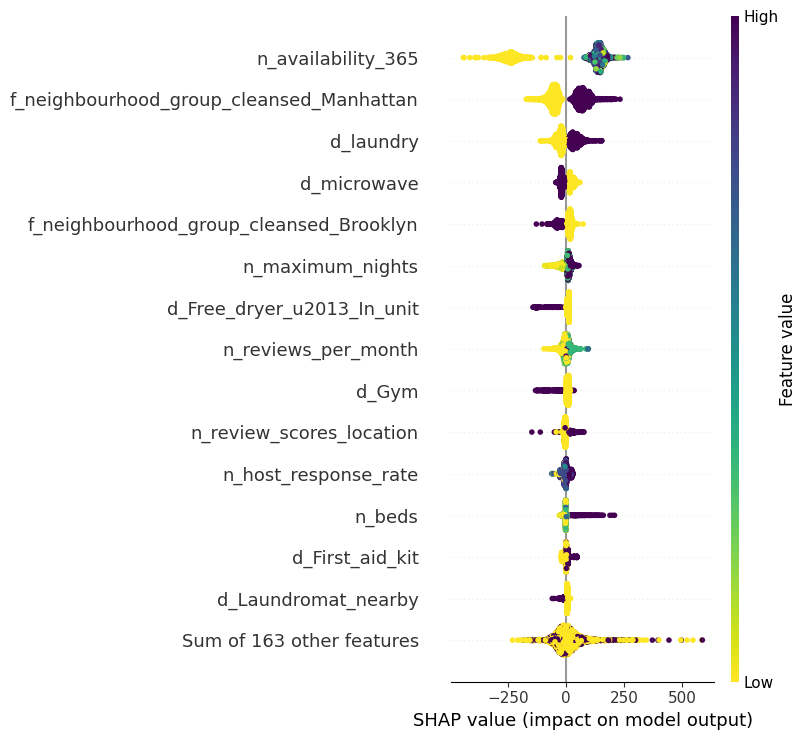

In [121]:
plt.figure(figsize=(10, 20))  # Adjust the size as needed
shap.plots.beeswarm(shap_values, max_display = 15, color=plt.get_cmap("viridis_r"), show=False)
plt.gcf().tight_layout()  # Adjust the layout to fit the feature names
plt.gcf().savefig('/Users/Admin/Desktop/oct_shap_beeswarm.png')

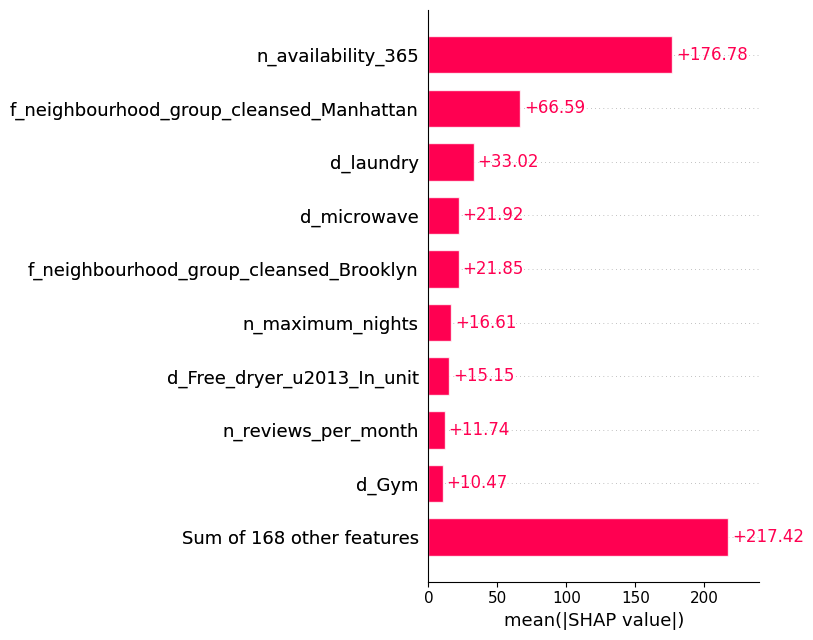

In [122]:
plt.figure(figsize=(10, 20))  # Adjust the size as needed
shap.plots.bar(shap_values, show=False)
plt.gcf().tight_layout()  # Adjust the layout to fit the feature names
plt.gcf().savefig('/Users/Admin/Desktop/oct_shap_bar.png')


In [124]:
plt.figure(figsize=(10, 20))  # Adjust the size as needed
shap.plots.waterfall(shap_values[2], show=False)
plt.gcf().tight_layout()  # Adjust the layout to fit the feature names
plt.gcf().savefig('/Users/Admin/Desktop/oct_shap_waterfall_2.png')